# First script inversion of the ZNS parameters

Thanks to this script we will carry out an inversion of the parameters of the unsaturated area, the porosity and the depth of the water table in steady state from a reference simulation sampled in 100 points. The heat transfer takes place in a one-dimensional soil of height 1m represented. 

The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the alpha Van Genuchten parameter $\alpha$,
- the $n$ Van Genuchten parameter, 
- the residual saturation $s_wres$, and
- the water table altitude (WT).


Fill the E_temperature_initiale.dat with the initial temperature profile





# O. Initiation Ginette files

In [15]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import itertools
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
libs_gfortran = ['gfortran']
# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/1D_col_2/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../src/ginette_V2.f"])  #creat

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=90

# state
## 0 steady state
# 1 transient state (dynamic state)
state=1

# size columnin meter
z_top=0
z_bottom=-1
az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01

#apply unsaturated flow and thermal 
#unsat =1 apply
#unsat=0 cancel unsaturated zone
unsat=1

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=1

# number of cell
nb_cell=z_top/dz


# Obs
Obs1=z_top-0.025
Obs2=z_top-0.05
Obs3=z_top-0.1
Obs4=z_top-0.2
Obs5=z_top-0.3
Obs6=z_top-0.4
Obs7=z_top-0.5
Obs8=z_top-0.8
Obs9=z_top-0.9
Obs10=z_bottom


nb_cell=abs(z_top-z_bottom)/dz
cell1=-Obs1/dz
cell2=-Obs2/dz
cell3=-Obs3/dz
cell4=-Obs4/dz
cell5=-Obs5/dz
cell6=-Obs6/dz
cell7=-Obs7/dz
cell8=-Obs8/dz
cell9=-Obs9/dz
cell10=-Obs10/dz
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
setup_model=setup_model.replace('[z_bottom]', '%7.3e' % z_bottom)
setup_model=setup_model.replace('[az]','%7.3e' % az)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)
setup_model=setup_model.replace('[unsat]','%1i' % unsat)
setup_model=setup_model.replace('[cell1]','%05d' % cell1)
setup_model=setup_model.replace('[cell2]','%05d' % cell2)
setup_model=setup_model.replace('[cell3]','%05d' % cell3)
setup_model=setup_model.replace('[cell4]','%05d' % cell4)
setup_model=setup_model.replace('[cell5]','%05d' % cell5)
setup_model=setup_model.replace('[cell6]','%05d' % cell6)
setup_model=setup_model.replace('[cell7]','%05d' % cell7)
setup_model=setup_model.replace('[cell8]','%05d' % cell8)
setup_model=setup_model.replace('[cell9]','%05d' % cell9)
setup_model=setup_model.replace('[cell10]','%05d' % cell10)

f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()




Current working directory: /home/ariviere/Programmes/ginette/application/1D_col_2
ginette exist




## 1. Reference simulation and sampling

We choose to use the average parameters given by Carsel and Parrish (1988) as reference values for all facies


In [16]:
import numpy as np
import pandas as pd
import array

# porosity
REF_n=0.40 # \Phi

# Van Genuchten parameters
REF_a=4.50000 #m-1 alpha_vg
REF_nVG= 1.7  # n_vg
REF_swres=0.1 # S_wr
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
val_k=1e-11
# solid grain density rho_s=val_r  [kg.m-3]
val_r=2578
# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 

REF_r=2650
REF_c=835
REF_l=2.5 #

# Boundary condition water level (meter)
REF_WT=0.4



# Initial conditions
f_IC_bck=open("E_cdt_initiale_backup.dat","r")
IC_model=f_IC_bck.read()
IC_model=IC_model.replace('[head_ini]', '%05.2fD+00' % REF_WT)
## write the boundary conditions
f_bc_bck=open("E_cdt_aux_limites_backup.dat", "r")
bc_model=f_bc_bck.read()
bc_model=bc_model.replace('[top]', '%08.2fD+00' % REF_WT)
bc_model=bc_model.replace('[bot]','%08.2fD+00' % REF_WT)
    ########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
f_paramZ_new = open("E_zone_parameter.dat", 'w')
f_bc_new = open("E_cdt_aux_limites.dat", 'w')
f_IC_new=open("E_cdt_initiale.dat","w")
param_zone=f_paramZ_bck.read()
coord=pd.DataFrame()    
#coord = pd.read_csv(f_coor, names=["id", "x", "z"], header=None, delim_whitespace=True)

# replace the parameter values
param_zone=param_zone.replace('[k1]','%8.2e' % val_k)
param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
param_zone=param_zone.replace('[r1]','%6.2f' % val_r)
param_zone=param_zone.replace('[a1]','%8.2e' % REF_a)
param_zone=param_zone.replace('[nVG1]','%6.2f' % REF_nVG)
param_zone=param_zone.replace('[swres1]','%6.2f' % REF_swres)
param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
param_zone=param_zone.replace('[c1]','%6.2f' % REF_c)
param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)
    
# calculate the coordinates to know the number of cell in the domain    
########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
coord=pd.DataFrame()
# calculate the coordinates to know the number of cell in the domain
zvalues = np.arange(-dz/2, z_bottom,-dz );
xvalues = np.array([0.5]);
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
"x": np.reshape(xx,NT),
"z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1
#Pour plusieurs zones modification AR
# if nb_zone >= 2:
# for i in range(2,int(nb_zone)+1):
# coord['zone'] = np.where(coord['z'] <= coord.loc[((i-1)*z_top*100/nb_zone),'z'], i,coord['zone'])


#coord['zone'] = np.where(coord['z'] <= coord.loc[i-1,'z'], i,coord['zone'])
#coord['zone'] = np.where(coord['z'] <= thk2, 2,coord['zone'])

#Write new ginette files
coord.zone.to_csv(f_zone, index = False, header=False)

# close files
f_zone.close()
f_coor.close()


    #Write new ginette files
f_IC_new.write(IC_model)
f_paramZ_new.write(param_zone)
f_bc_new.write(bc_model)
        
    
# close files    
f_zone.close()
f_coor.close()
f_paramZ_new.close()
f_paramZ_bck.close()

f_IC_new.close()
f_bc_bck.close()
f_bc_new.close()
f_coor.close()


# run ginette
subprocess.call(["./ginette"])
    




   900.00000000000000        900.00000000000000       -1.5065358476650070       -1.5011089608758312     
 bas=  -1.4960204081632653     
 pluie=   0.0000000000000000      mm/j
 sat=  0.13372147916481744     
   1800.0000000000000        900.00000000000000       -1.5065398920539930       -1.5010569640815301     
 bas=  -1.4960204081632653     
 pluie=   0.0000000000000000      mm/j
 sat=  0.13372116604235110     
   2700.0000000000000        900.00000000000000       -1.5065432636842697       -1.5010458207172106     
 bas=  -1.4960204081632653     
 pluie=   0.0000000000000000      mm/j
 sat=  0.13372090490787394     
   3600.0000000000000        900.00000000000000       -1.5065462151937683       -1.5010409769520252     
 bas=  -1.4960204081632653     
 pluie=   0.0000000000000000      mm/j
 sat=  0.13372067625569423     
   4500.0000000000000        900.00000000000000       -1.5065488811365229       -1.5010383012692194     
 bas=  -1.4960204081632653     
 pluie=   0.0000000000000000   

0

# Profile saturation référence au bout de 2 jours

In [17]:
# read the saturation profil   
saturation_profile_REF = pd.read_table('S_saturation_profil_t.dat',delim_whitespace=True,header=None)
saturation_profile_REF.columns=[ "time",  "z","sat"]
saturation_profile_REF=saturation_profile_REF.iloc[saturation_profile_REF.index.stop-int(nb_cell):saturation_profile_REF.index.stop]


/tmp/ipykernel_249077/3646361116.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


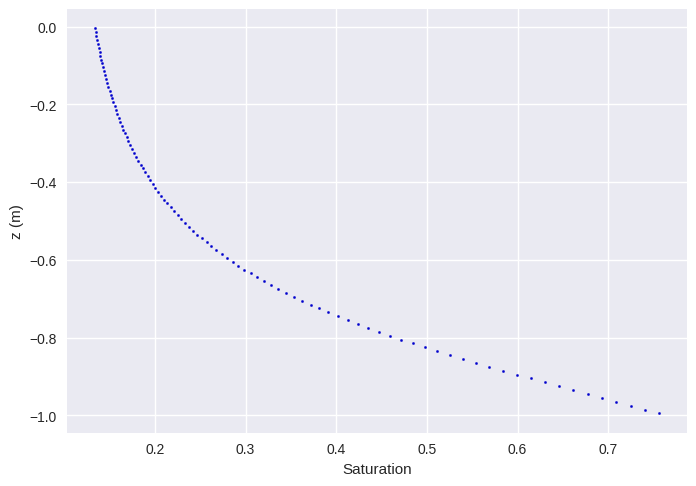

In [18]:
plt.figure()
plt.style.use('seaborn')

plt.scatter(saturation_profile_REF.sat,saturation_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
plt.xlabel('Saturation')
plt.xlabel('Saturation')
plt.ylabel('z (m)')
plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm  # Import LogNorm for logarithmic scaling
saturation_profile = pd.read_table('S_saturation_profil_t.dat',delim_whitespace=True,header=None)
saturation_profile.columns=[ "time",  "z","sat"]
saturation_profile['Day']=saturation_profile['time']/86400
time_max=max(saturation_profile["time"])
# Votre code pour l'interpolation de la saturation
time_grid = np.linspace(min(saturation_profile["time"]), max(saturation_profile["time"]), 100000)
depth_grid = np.linspace(min(saturation_profile["z"]), max(saturation_profile["z"]), 100)
time_grid, depth_grid = np.meshgrid(time_grid, depth_grid)



In [20]:
# Création d'une séquence de temps de 0 à tmax avec un pas de 900 secondes (delta t)
time_sequence = pd.Series(range(0, int(time_max) + 1, 900))  # +1 pour inclure tmax lui-même

# Création d'une nouvelle dataframe contenant uniquement la colonne "time"
time_df = pd.DataFrame({'time': time_sequence})

saturation_interpolated = griddata(
    (saturation_profile["Day"], saturation_profile["z"]),
    saturation_profile["sat"],
    (time_grid, depth_grid),
    method='linear'
)

In [21]:
vitesse_profile=pd.read_table('Sim_velocity_profil_t.dat',delim_whitespace=True,header=None)
vitesse_profile.columns=[ "time",  "z","vit"]
vitesse_profile['Day']=vitesse_profile['time']/86400
vitesse_profile['vit']=abs(vitesse_profile['vit'])



vitesse_interpolated = griddata(
    (vitesse_profile["Day"], vitesse_profile["z"]),
    vitesse_profile["vit"],
    (time_grid, depth_grid),
    method='linear'
)


In [22]:


pluie= pd.read_table('E_ec_bc_t.dat',delim_whitespace=True,header=None)
pluie.columns=[ "BC_top",  "BC_bot"]
# Fusionner cette dataframe avec votre dataframe existante (df) en ajoutant la colonne "time"
# Ajout de la colonne 'time' à vos données de pluie
pluie['time'] = time_sequence
pluie['Day']=pluie['time']/86400

In [23]:
# Définition de l'échelle pour la colorbar en utilisant l'échelle logarithmique
vmin_log = min(vitesse_profile['vit'])  # Utilisation du logarithme du minimum des vitesses positives
vmax_log = max(vitesse_profile['vit'])  # Utilisation du logarithme du maximum des vitesses positives
vmin_log

0.0

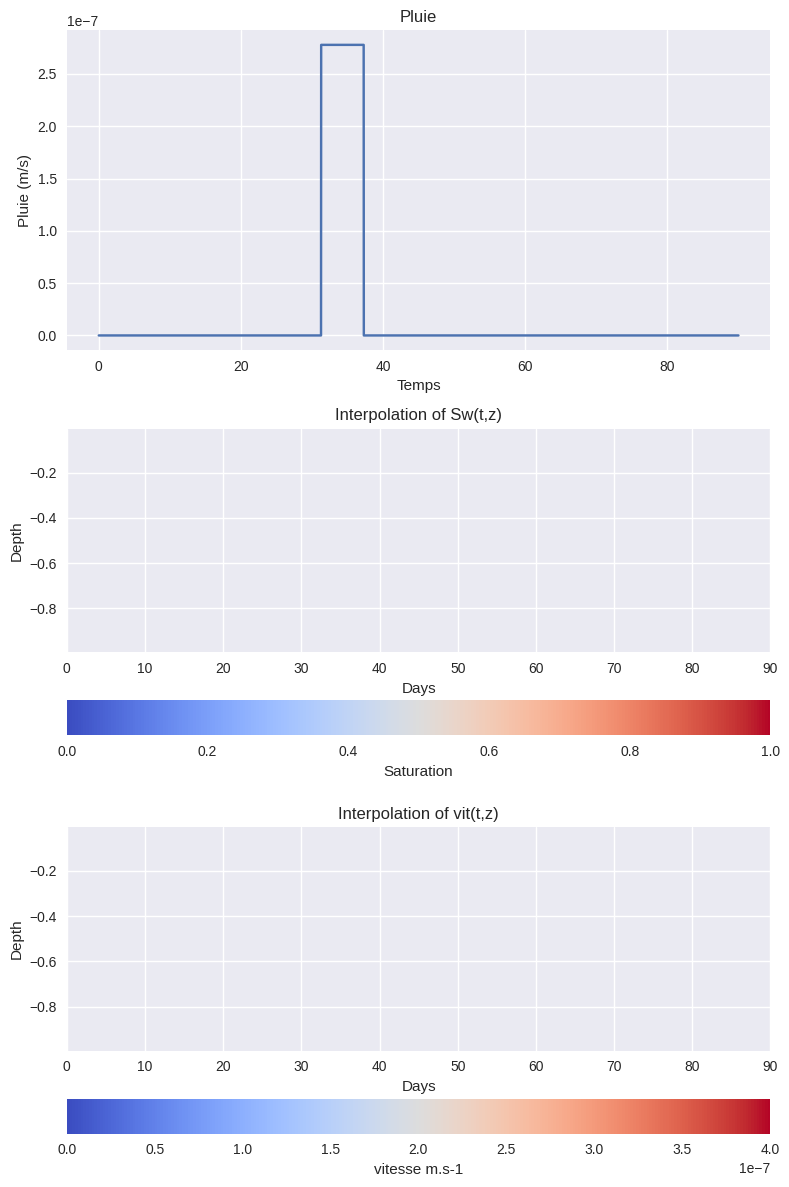

In [24]:
# Deuxième figure - Interpolation de la température
time_grid = np.linspace(0, max(temp_BC['Day']), 1000)
depth_grid = np.linspace(min(temperature_profile["z"]), max(temperature_profile["z"]), 100)
time_grid, depth_grid = np.meshgrid(time_grid, depth_grid)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot for pluie
ax1.plot(pluie['Day'], pluie['BC_top'], label='Pluie')
ax1.set_title('Pluie')
ax1.set_xlabel('Temps')
ax1.set_ylabel('Pluie (m/s)')
ax1.grid(True)

# Plot for saturation interpolation
im = ax2.imshow(saturation_interpolated, extent=(0, max(saturation_profile["Day"]), min(saturation_profile["z"]), max(saturation_profile["z"])), origin='lower', aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar(im, ax=ax2, label='Saturation', location='bottom')
ax2.set_title('Interpolation of Sw(t,z)')
ax2.set_xlabel('Days')
ax2.set_ylabel('Depth')
ax2.grid(True)



# Plot pour l'interpolation des vitesses (valeurs logarithmiques)
im = ax3.imshow(vitesse_interpolated, extent=(0, max(vitesse_profile["Day"]), min(vitesse_profile["z"]), max(vitesse_profile["z"])),
                origin='lower', aspect='auto', cmap='coolwarm', vmin=vmin_log, vmax=vmax_log)
plt.colorbar(im, ax=ax3, label='vitesse m.s-1', location='bottom')

# Autres paramètres pour le tracé
ax3.set_title('Interpolation of vit(t,z)')
ax3.set_xlabel('Days')
ax3.set_ylabel('Depth')
ax3.grid(True)

plt.tight_layout()
plt.show()



 # Profile de temperature au bout de 2 jours

/tmp/ipykernel_249077/1267379805.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


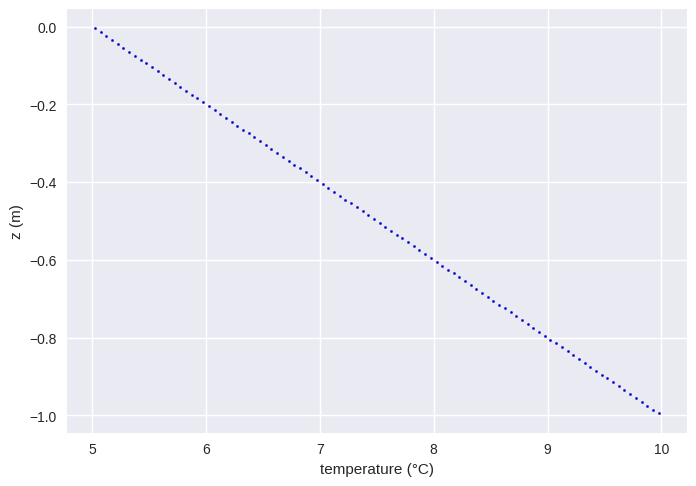

In [25]:
# read the temperature profile   
temperature_profile_REF = pd.read_table('Sim_temperature_profil_t.dat',delim_whitespace=True,header=None)
temperature_profile_REF.columns=[ "time",  "z","temp"]
temperature_profile_REF=temperature_profile_REF.iloc[temperature_profile_REF.index.stop-int(nb_cell):temperature_profile_REF.index.stop]

plt.figure()
plt.style.use('seaborn')

plt.scatter(temperature_profile_REF.temp,temperature_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
plt.xlabel('temperature (°C)')
plt.ylabel('z (m)')
plt.show()


In [26]:
# read the temperature profile   
temperature_profile = pd.read_table('Sim_temperature_profil_t.dat',delim_whitespace=True,header=None)
temperature_profile.columns=[ "time",  "z","temp"]
temperature_profile['Day']=temperature_profile['time']/86400

/tmp/ipykernel_249077/1862014090.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


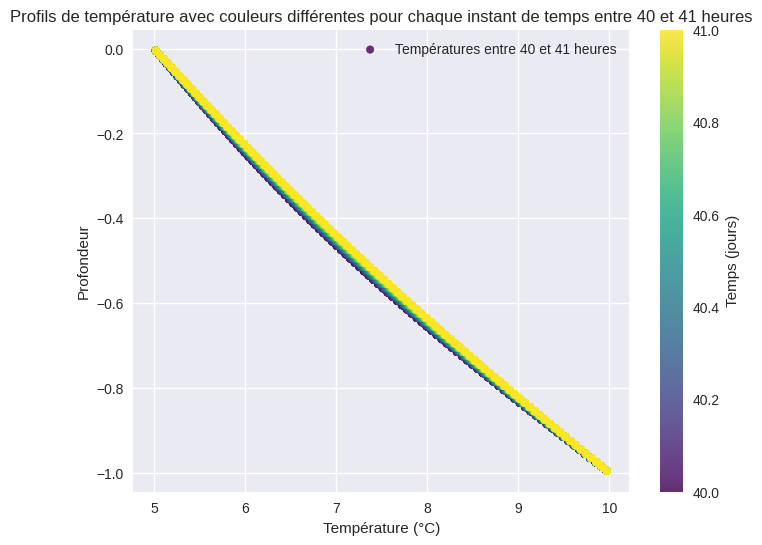

In [27]:
temperature_between_40_41 = temperature_profile[(temperature_profile['Day'] >= 40) & (temperature_profile['Day'] <= 41)]
# Création d'une colormap pour représenter les instants de temps
time_values = temperature_between_40_41['Day'].values
norm = plt.Normalize(time_values.min(), time_values.max())
cmap = plt.cm.get_cmap('viridis')

# Tracé des profils de température avec des couleurs différentes pour chaque instant de temps
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    temperature_between_40_41['temp'],
    temperature_between_40_41['z'],
    s=30,
    c=time_values,
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    label='Températures entre 40 et 41 heures'
)

plt.colorbar(sc, label='Temps (jours)')
plt.xlabel('Température (°C)')
plt.ylabel('Profondeur')
plt.title('Profils de température avec couleurs différentes pour chaque instant de temps entre 40 et 41 heures')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
temp_BC= pd.read_table('E_temp_t.dat',delim_whitespace=True,header=None)
temp_BC.columns=[ "BC_top",  "BC_bot"]
# Fusionner cette dataframe avec votre dataframe existante (df) en ajoutant la colonne "time"
# Ajout de la colonne 'time' à vos données de pluie
temp_BC['time'] = time_sequence
temp_BC['Day']=temp_BC['time']/86400

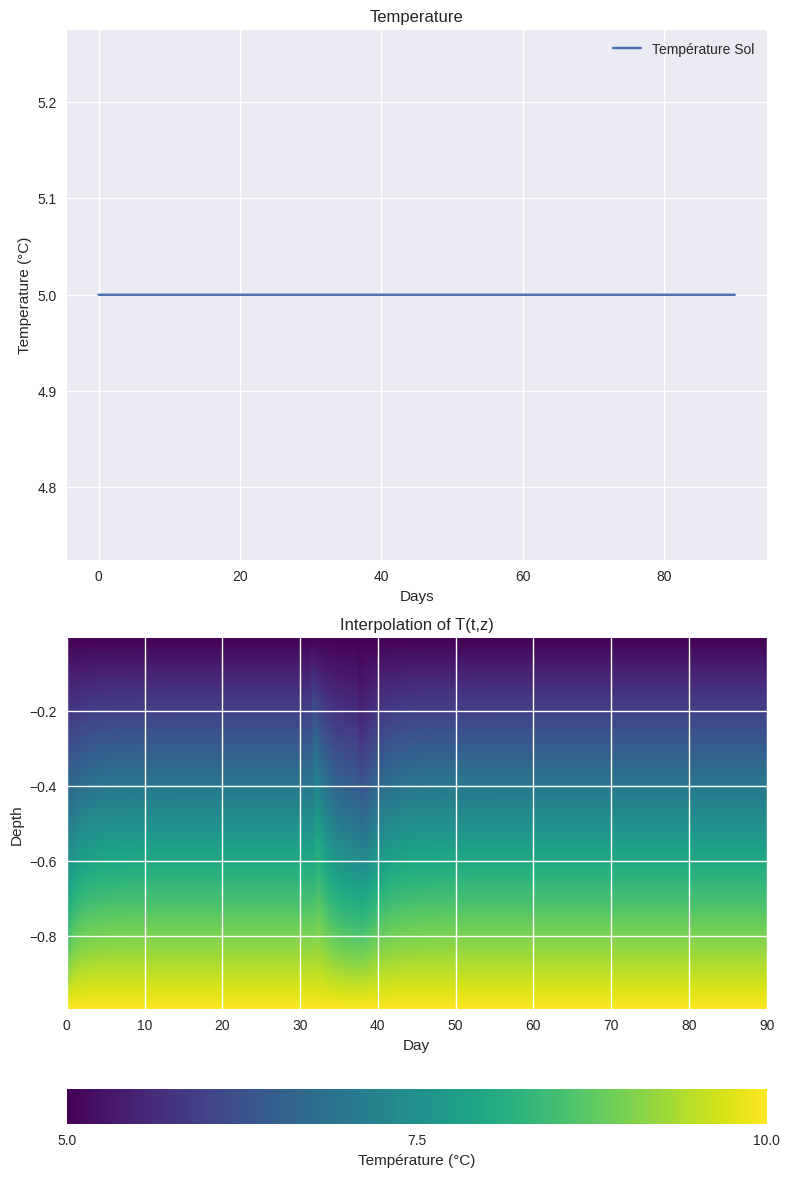

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Vos données de température (temp_BC et temperature_profile)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Première figure - Tracé des données de température
ax1.plot(temp_BC['Day'], temp_BC['BC_top'], label='Température Sol')
ax1.set_title('Temperature')
ax1.set_xlabel('Days')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True)
ax1.legend()

# Deuxième figure - Interpolation de la température
time_grid = np.linspace(0, max(temp_BC['Day']), 1000)
depth_grid = np.linspace(min(temperature_profile["z"]), max(temperature_profile["z"]), 100)
time_grid, depth_grid = np.meshgrid(time_grid, depth_grid)

temperature_interpolated = griddata(
    (temperature_profile["Day"], temperature_profile["z"]),
    temperature_profile["temp"],
    (time_grid, depth_grid),
    method='linear'
)

# Affichage du graphique avec l'interpolation de température
im = ax2.imshow(temperature_interpolated, extent=(0, max(temperature_profile["Day"]), min(temperature_profile["z"]), max(temperature_profile["z"])), origin='lower', aspect='auto', cmap='viridis', vmin=5, vmax=10)
cbar = plt.colorbar(im, ax=ax2, label='Température (°C)', orientation='horizontal')
cbar.set_ticks([5, 7.5, 10])  # Définir les graduations de la barre de couleur
ax2.set_title('Interpolation of T(t,z)')
ax2.set_xlabel('Day')
ax2.set_ylabel('Depth')
ax2.grid(True)

plt.tight_layout()
plt.show()



In [30]:
heat_fluxes= pd.read_table('Sim_heat_flux_profil_t.dat',delim_whitespace=True,header=None)
heat_fluxes.columns=[ "time","z","cond","adv",'tot']
heat_fluxes['Day']=temperature_profile['time']/86400


In [31]:
cond_interpolated = griddata(
    (heat_fluxes["Day"], heat_fluxes["z"]),
    heat_fluxes["cond"],
    (time_grid, depth_grid),
    method='linear'
)
adv_interpolated = griddata(
    (heat_fluxes["Day"], heat_fluxes["z"]),
    heat_fluxes["cond"],
    (time_grid, depth_grid),
    method='linear'
)

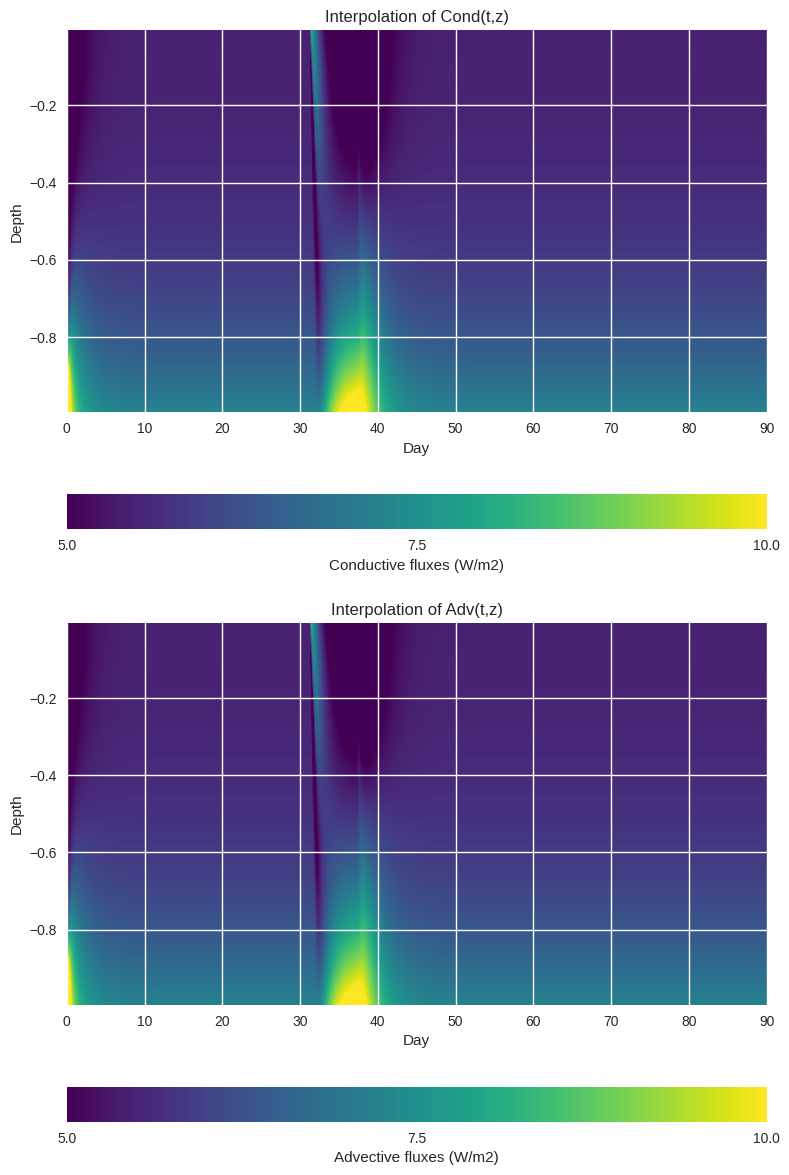

In [33]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Affichage du graphique avec l'interpolation de température
im = ax1.imshow(cond_interpolated, extent=(0, max(heat_fluxes["Day"]), min(heat_fluxes["z"]), max(heat_fluxes["z"])), origin='lower', aspect='auto', cmap='viridis', vmin=5, vmax=10)
cbar = plt.colorbar(im, ax=ax1, label='Conductive fluxes (W/m2)', orientation='horizontal')
cbar.set_ticks([5, 7.5, 10])  # Définir les graduations de la barre de couleur
ax1.set_title('Interpolation of Cond(t,z)')
ax1.set_xlabel('Day')
ax1.set_ylabel('Depth')
ax1.grid(True)


# Affichage du graphique avec l'interpolation de température
im = ax2.imshow(adv_interpolated, extent=(0, max(heat_fluxes["Day"]), min(heat_fluxes["z"]), max(heat_fluxes["z"])), origin='lower', aspect='auto', cmap='viridis', vmin=5, vmax=10)
cbar = plt.colorbar(im, ax=ax2, label='Advective fluxes (W/m2)', orientation='horizontal')
cbar.set_ticks([5, 7.5, 10])  # Définir les graduations de la barre de couleur
ax2.set_title('Interpolation of Adv(t,z)')
ax2.set_xlabel('Day')
ax2.set_ylabel('Depth')
ax2.grid(True)

plt.tight_layout()
plt.show()

